# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [128]:
### import statements
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from pylab import rcParams
import tensorflow as tf
import pickle
import time
import os
from PIL import Image
%matplotlib inline

In [129]:
### Load pickled data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [130]:
### Basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


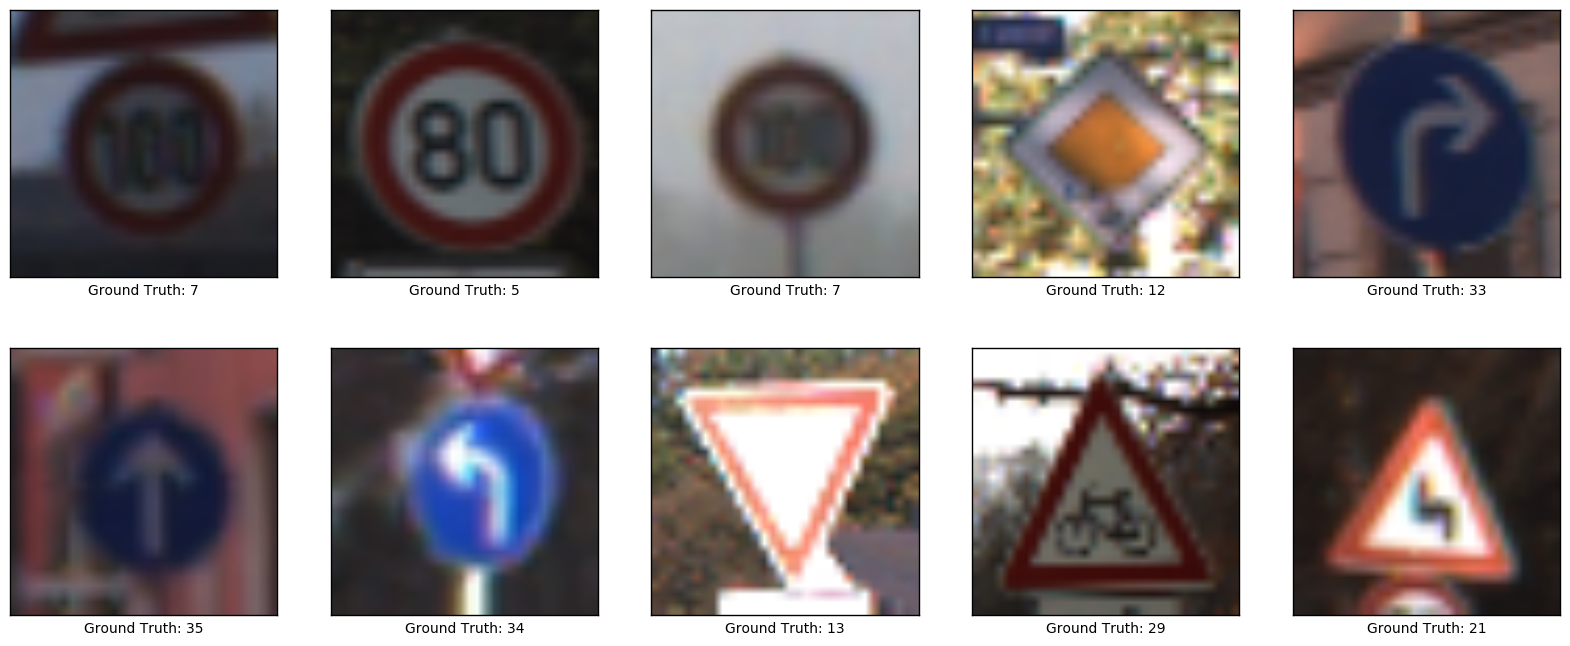

In [208]:
### Data exploration visualization
fig = plt.figure(figsize=(20, 8))

image_seq = np.random.randint(1,len(X_train),10)

for ind,val in enumerate(image_seq):
    img = fig.add_subplot(2,5,ind+1)
    plt.imshow(X_train[val-1])
    #Add corresponding label
    img.set_xlabel("Ground Truth: {0}".format(y_train[val-1]))
    #Remove the axis ticks
    img.set_xticks([])
    img.set_yticks([])

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [132]:
### Preprocess data
# Grayscale conversion
'''
Weighted average approach utilizing numpy functions. No need for OpenCV
Y' = 0.299 R + 0.587 G + 0.114 B 
'''
#X_train_gray = np.dot(X_train[...][...,:3],[0.299,0.587,0.114])
#X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])

X_train_gray = X_train
X_test_gray = X_test

# Normalize data (Zero-Mean)
X_train_gray_norm = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
X_test_gray_norm = (X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

In [133]:
### One-Hot Encoding
'''
Since we already have the labels we can use Label Binarizer.
'''
encoder = preprocessing.LabelBinarizer()
y_train_oh = encoder.fit_transform(y_train)
y_test_oh = encoder.fit_transform(y_test)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [134]:
### Split and shuffle data
'''
Use sklearn to split training data into training and validation set. Keep test data for test set.
'''
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_gray_norm, y_train_oh, test_size=0.15, random_state=422016)

train_features, train_labels = shuffle(train_features, train_labels)
valid_features, valid_labels = shuffle(valid_features, valid_labels)

In [135]:
# Flatten/Reshape data
image_size = len(train_features[0])
n_input = image_size**2
num_channels = 3 # grayscale

train_features_f = np.reshape(train_features, [-1, image_size, image_size, num_channels])
valid_features_f = np.reshape(valid_features, [-1, image_size, image_size, num_channels])
X_test_gray_flat = np.reshape(X_test_gray_norm, [-1, image_size, image_size, num_channels])

# For initial testing
'''
train_features_f = train_features_f1[:501]
valid_features_f = valid_features_f1[:501]
train_labels = train_labels_1[:501]
valid_labels = valid_labels_1[:501]
'''

'\ntrain_features_f = train_features_f1[:501]\nvalid_features_f = valid_features_f1[:501]\ntrain_labels = train_labels_1[:501]\nvalid_labels = valid_labels_1[:501]\n'

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [183]:
### Helper Functions
def calc_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.01))


def calc_biases(length):
    return tf.Variable(tf.zeros(length))


def maxpool(ip, stride_len = 2):
    filter_size = [1, stride_len, stride_len, 1]
    return tf.nn.max_pool(ip, ksize = filter_size, strides = [1, stride_len, stride_len, 1], padding = 'VALID')

def dropout(layer, dropout_prob):
    return tf.nn.dropout(layer, dropout_prob)


def conv_layer(ip, weights, biases, stride_len = 1):
    '''
    input_layer_width -> Number of inputs from previous layer
    output_layer_width -> width of layer
    '''  
    c_layer = tf.nn.conv2d(ip, weights, strides = [1, stride_len, stride_len, 1], padding = 'VALID')
    c_layer = tf.nn.bias_add(c_layer, biases)
    
    c_layer = maxpool(c_layer, 2) #stride length for max_pool = 2
    
    c_layer = tf.nn.relu(c_layer)
    return c_layer


def reshape_layer(ip):
    '''
    Flatten or reshape conv_layer for input to fc_layer
    '''
    flat_layer = tf.reshape(ip, [-1, ip.get_shape()[1:4].num_elements()])
    
    #print("Flat Layer: %s" %flat_layer.get_shape())
    
    return flat_layer

def fully_conn_layer(ip, weights, biases):
    '''
    input_layer_width -> Number of inputs from previous flattened layer
    output_layer_width -> width of layer, or equal to number of classes for prediction layer
    '''  
    flat_input = reshape_layer(ip)
    fc_layer = tf.add(tf.matmul(flat_input, weights), biases)
    
    #print("FC Layer: %s" %fc_layer.get_shape())
    #Not applying ReLU here because this could be prediction layer
    return fc_layer

def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=test_cls,
                              y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)
    
    rcParams['figure.figsize'] = 13,13
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def print_test_accuracy():
    test_cls = np.argmax(y_test_oh, axis=1)
    cls_pred = np.zeros(shape=n_test, dtype=np.int)
    i = 0

    while i < n_test:
        j = min(i + batch_size, n_test)

        batch_x = X_test_gray_flat[i:j]
        batch_y = y_test_oh[i:j]
        
        feed_dict={network_input: batch_x, network_output: batch_y, keep_prob: 1.0}

        cls_pred[i:j] = session.run(label_pred_class, feed_dict=feed_dict)

        i = j
    print(cls_pred)
    correct = (test_cls == cls_pred)
    correct_sum = correct.sum()

    acc = float(correct_sum) / n_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, n_test))

    plot_confusion_matrix(cls_pred=cls_pred)


In [184]:
### Convnet model
def convnet_model(ip, weights_dict, biases_dict, dropout_prob):
    
    #print(ip.get_shape())
    #First conv layer
    c_layer_1 = conv_layer(ip, weights_dict['layer_1'], biases_dict['layer_1'], stride_len = 1)
    c_layer_1 = dropout(c_layer_1, dropout_prob)
    
    #Second conv layer
    c_layer_2 = conv_layer(c_layer_1, weights_dict['layer_2'], biases_dict['layer_2'], stride_len = 1)
    c_layer_2 = dropout(c_layer_2, dropout_prob)
    
    '''
    #Second conv layer
    c_layer_3 = conv_layer(c_layer_2, weights_dict['layer_3'], biases_dict['layer_3'], stride_len = 1)
    c_layer_3 = dropout(c_layer_3, dropout_prob)
    '''
    #FC Layer
    fc_layer = fully_conn_layer(c_layer_2, weights_dict['fc_layer'], biases_dict['fc_layer'])
    
    fc_layer = tf.nn.relu(fc_layer)
    fc_layer = dropout(fc_layer, dropout_prob)
    #print(fc_layer.get_shape())
    #Output fc layer
    out = fully_conn_layer(fc_layer, weights_dict['out'], biases_dict['out'])
    
    #print(out.get_shape())
    return out  
    

In [185]:
# Dimensions
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    #'layer_3': 128,
    'fc_layer': 1024,
    'out': n_classes
} # number of filters

filter_size = {
    'layer_1': 5,
    'layer_2': 5
} # conv filter size


# Weights and biases
weights_dict = {
    'layer_1': calc_weights([filter_size['layer_1'], filter_size['layer_1'] , num_channels, layer_width['layer_1']]),
    'layer_2': calc_weights([filter_size['layer_2'], filter_size['layer_2'] , layer_width['layer_1'], layer_width['layer_2']]),
    #'layer_3': calc_weights([filter_size['layer_2'], filter_size['layer_2'] , layer_width['layer_2'], layer_width['layer_3']]),
    'fc_layer': calc_weights([ 1600, layer_width['fc_layer']]),
    'out': calc_weights([layer_width['fc_layer'], layer_width['out']])
}

biases_dict = {
    'layer_1': calc_biases([layer_width['layer_1']]),
    'layer_2': calc_biases([layer_width['layer_2']]),
    #'layer_3': calc_biases([layer_width['layer_3']]),
    'fc_layer': calc_biases([layer_width['fc_layer']]),
    'out': calc_biases([layer_width['out']])
}

In [186]:
# Define Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 64
display_step = 1

In [187]:
# Input graph for TF
network_input = tf.placeholder("float", [None, image_size, image_size, num_channels])
network_output = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

logits = convnet_model(network_input, weights_dict, biases_dict, keep_prob)
'''
# Check if predictions are correct.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(network_output, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


'''

label_pred = tf.nn.softmax(logits)
label_pred_class = tf.argmax(label_pred, 1)

# Cost function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, network_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Check if predictions are correct.
correct_prediction = tf.equal(label_pred_class, tf.argmax(network_output, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Initialize variables
#init = tf.global_variables_initializer()
init = tf.initialize_all_variables()

batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

total_time = time.time()
# Launch graph
session = tf.Session()
session.run(init)
    
# Training cycle
for epochs in range(training_epochs):
    start_time = time.time()
    avg_cost = 0.
    total_batch = int(len(train_features)/batch_size)

    train_features_f, train_labels = shuffle(train_features_f, train_labels)
    valid_features_f, valid_labels = shuffle(valid_features_f, valid_labels)

    for i in range(total_batch):
        idx_l = i*batch_size
        idx_h = idx_l + batch_size

        batch_x = train_features_f[idx_l:idx_h]
        batch_y = train_labels[idx_l:idx_h]

        _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x, network_output: batch_y, keep_prob: 0.5})

        # Compute average loss
        avg_cost += c / total_batch


    # Log every 50 batches
        if not i % 50:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict={network_input: train_features_f, 
                                                                 network_output: train_labels, keep_prob: 0.5 })
            validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, 
                                                                   network_output: valid_labels, keep_prob: 1})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(50 + previous_batch)
            loss_batch.append(c)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)


    # Display logs per epoch step
    if epochs % display_step == 0:
        print("Epoch:", '%04d' % (epochs+1), "cost=", \
            "{:.9f}".format(avg_cost))
    end_time = time.time() - start_time
    print("Time after epoch: %s" %end_time)

    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict={network_input: valid_features_f, 
                                                           network_output: valid_labels, keep_prob: 1})

print("Optimization Finished!")

test_accuracy = session.run(accuracy, feed_dict = 
                                        {network_input: X_test_gray_flat, network_output: y_test_oh, keep_prob: 1})
print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:", test_accuracy)

plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch)

final_time = time.time() - total_time
print("Time taken: %s" %final_time)

In [ ]:
#Confusion Matrix
print_test_accuracy()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

images = os.listdir("test_images/")

fig = plt.figure(figsize=(20, 8))

test_images = []

# Read in test images
for idx,val in enumerate(images):
    #reading in an image
    image = mpimg.imread('test_images/' + images[idx])
    test_images.append(image)
    
# Create subplots in figure
for r in range(1,len(test_images)+1):
    img = fig.add_subplot(5,1,r)
    plt.imshow(test_images[r-1])
    img.set_xticks([])
    img.set_yticks([])

plt.show()

In [ ]:
### Preprocess images
# The images are already 32x32

# Normalize data (Zero-Mean)
test_images_norm = (test_images - np.mean(test_images))/np.std(test_images)

# Reshape
test_images_norm_f = np.reshape(test_images_norm, [-1, image_size, image_size, num_channels])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

for i in range(len(test_images_norm_f)):
    new_predictions = session.run(label_pred, feed_dict = {network_input: test_images_norm_f, keep_prob: 1.0})
print(new_predictions)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.